# Packages

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import umap
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from modules.sparse_autoencoder import *
import pickle
from tqdm import tqdm
from modules.deg_analysis import *
from modules.visualize import *
from sklearn.neighbors import NearestNeighbors

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-25 13:30:04.972328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 13:30:05.637986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import dataset and annotation

In [ ]:
# sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
#                       'SampleTag18_flex':'3xTg-DMSO',
#                       'SampleTag19_flex':'WT-SCDi',
#                       'SampleTag20_flex':'3xTg-SCDi',
#                       'Undetermined':'Undetermined',
#                       'Multiplet':'Multiplet'}
# adata = anndata.read_h5ad("data/fede_count.h5ad")
# adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
# anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

In [2]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 'LD_5xFAD'
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = "LD_NC"
adata3 = anndata.read_h5ad("data/C_count.h5ad")
adata3.obs['Sample_Tag'] = "run_5xFAD"
adata4 = anndata.read_h5ad("data/D_count.h5ad")
adata4.obs['Sample_Tag'] = "run_NC"
adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)

anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata = annotate_adata(adata, anno_df)

# Data preprocessing

In [4]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 5

In [8]:
adata = adata[~adata.obs['high_mt'], :]
adata = adata[adata.obs['Sample_Tag'] != "Multiplet", :]

In [9]:
adata = adata[:, ~adata.var['mt']]

# Train/Test split

In [10]:
train_indices, test_indices = train_test_split(np.arange(adata.n_obs), test_size=0.2, random_state=42)
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()
train_dataset = AnnDataDataset(adata_train)
test_dataset = AnnDataDataset(adata_test)
n_inputs = adata.var.index.values.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Train model

In [11]:
autoencoder = Autoencoder(n_latents=32, 
                          n_inputs=n_inputs, 
                          activation=TopK(k=16), 
                          tied=True, 
                          normalize=True)
autoencoder.to(device)

train_autoencoder(autoencoder, 
                  train_loader, 
                  test_loader,
                  device,
                  num_epochs=100, 
                  learning_rate=0.0001, 
                  prune_interval=10,
                  prune_amount=0.95)

100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.32it/s]
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Epoch 1/100, Loss: 1.4387874603271484, Test Loss: 2.196637609721841
Saved new best model with test loss: 2.196637609721841


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.60it/s]


Epoch 2/100, Loss: 4.373868465423584, Test Loss: 1.9196119374922804
Saved new best model with test loss: 1.9196119374922804


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 37.24it/s]


Epoch 3/100, Loss: 0.9064618945121765, Test Loss: 1.7668387436786213
Saved new best model with test loss: 1.7668387436786213


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.02it/s]


Epoch 4/100, Loss: 0.953348696231842, Test Loss: 1.6195811993769698
Saved new best model with test loss: 1.6195811993769698


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.52it/s]


Epoch 5/100, Loss: 0.539019763469696, Test Loss: 1.517879950637753
Saved new best model with test loss: 1.517879950637753


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.33it/s]


Epoch 6/100, Loss: 0.7733699679374695, Test Loss: 1.4184547435190227
Saved new best model with test loss: 1.4184547435190227


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.94it/s]


Epoch 7/100, Loss: 0.7915166616439819, Test Loss: 1.319092422119669
Saved new best model with test loss: 1.319092422119669


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.75it/s]


Epoch 8/100, Loss: 1.1397688388824463, Test Loss: 1.264335582183825
Saved new best model with test loss: 1.264335582183825


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.34it/s]


Epoch 9/100, Loss: 0.6311671137809753, Test Loss: 1.205656354290408
Saved new best model with test loss: 1.205656354290408


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.72it/s]


Pruning applied at epoch 10
Epoch 10/100, Loss: 0.911459743976593, Test Loss: 1.3931116779913773


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.28it/s]


Epoch 11/100, Loss: 0.6288615465164185, Test Loss: 1.106811877239395
Saved new best model with test loss: 1.106811877239395


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.80it/s]


Epoch 12/100, Loss: 0.4768275022506714, Test Loss: 1.065783207682339
Saved new best model with test loss: 1.065783207682339


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.42it/s]


Epoch 13/100, Loss: 1.00274658203125, Test Loss: 1.0307145887935483
Saved new best model with test loss: 1.0307145887935483


100%|█████████████████████████████████████████| 295/295 [00:06<00:00, 43.61it/s]


Epoch 14/100, Loss: 3.7545790672302246, Test Loss: 0.9781498407592645
Saved new best model with test loss: 0.9781498407592645


100%|█████████████████████████████████████████| 295/295 [00:06<00:00, 45.67it/s]


Epoch 15/100, Loss: 0.597439706325531, Test Loss: 0.9684020832583711
Saved new best model with test loss: 0.9684020832583711


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.12it/s]


Epoch 16/100, Loss: 0.40983545780181885, Test Loss: 0.9358521401882172
Saved new best model with test loss: 0.9358521401882172


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.37it/s]


Epoch 17/100, Loss: 1.0837820768356323, Test Loss: 0.9253713508715501
Saved new best model with test loss: 0.9253713508715501


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.29it/s]


Epoch 18/100, Loss: 0.9349510073661804, Test Loss: 0.910134032771394
Saved new best model with test loss: 0.910134032771394


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 41.34it/s]


Epoch 19/100, Loss: 0.5534834861755371, Test Loss: 0.8941166974805497
Saved new best model with test loss: 0.8941166974805497


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 41.33it/s]


Pruning applied at epoch 20
Epoch 20/100, Loss: 0.8661499619483948, Test Loss: 1.0670536526957073


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 41.99it/s]


Epoch 21/100, Loss: 0.7043965458869934, Test Loss: 0.8726722545720436
Saved new best model with test loss: 0.8726722545720436


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.60it/s]


Epoch 22/100, Loss: 0.6917083263397217, Test Loss: 0.8890050061651178


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.87it/s]


Epoch 23/100, Loss: 0.3215523660182953, Test Loss: 0.8733172013952926


100%|█████████████████████████████████████████| 295/295 [00:06<00:00, 45.61it/s]


Epoch 24/100, Loss: 0.5347292423248291, Test Loss: 0.8738890878252081


100%|█████████████████████████████████████████| 295/295 [00:06<00:00, 45.73it/s]


Epoch 25/100, Loss: 0.3126480281352997, Test Loss: 0.8560040119934726
Saved new best model with test loss: 0.8560040119934726


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.26it/s]


Epoch 26/100, Loss: 0.47191321849823, Test Loss: 0.851217162568827
Saved new best model with test loss: 0.851217162568827


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.17it/s]


Epoch 27/100, Loss: 0.6463914513587952, Test Loss: 0.8509782544664435
Saved new best model with test loss: 0.8509782544664435


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.65it/s]


Epoch 28/100, Loss: 0.4694742262363434, Test Loss: 0.9022337975534233


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.10it/s]


Epoch 29/100, Loss: 0.36762434244155884, Test Loss: 0.8403031105125273
Saved new best model with test loss: 0.8403031105125273


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.11it/s]


Pruning applied at epoch 30
Epoch 30/100, Loss: 0.16578125953674316, Test Loss: 1.0094862844090204


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.27it/s]


Epoch 31/100, Loss: 0.8941447138786316, Test Loss: 0.8318847999782175
Saved new best model with test loss: 0.8318847999782175


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.23it/s]


Epoch 32/100, Loss: 0.7499592304229736, Test Loss: 0.8439684514258359


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 41.40it/s]


Epoch 33/100, Loss: 0.4709434509277344, Test Loss: 0.8311191440836804
Saved new best model with test loss: 0.8311191440836804


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.96it/s]


Epoch 34/100, Loss: 1.7293674945831299, Test Loss: 0.8328050407203468


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.56it/s]


Epoch 35/100, Loss: 0.4843960702419281, Test Loss: 0.830384957226547
Saved new best model with test loss: 0.830384957226547


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.57it/s]


Epoch 36/100, Loss: 0.444857656955719, Test Loss: 0.8173149626802754
Saved new best model with test loss: 0.8173149626802754


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.42it/s]


Epoch 37/100, Loss: 1.570169448852539, Test Loss: 0.8206641883463472


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.55it/s]


Epoch 38/100, Loss: 0.33806541562080383, Test Loss: 0.8231794737480782


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 35.86it/s]


Epoch 39/100, Loss: 0.2811890244483948, Test Loss: 0.8122033805057809
Saved new best model with test loss: 0.8122033805057809


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.48it/s]


Pruning applied at epoch 40
Epoch 40/100, Loss: 0.4186401665210724, Test Loss: 0.9669181080283346


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.12it/s]


Epoch 41/100, Loss: 5.839292049407959, Test Loss: 0.8098034041153418
Saved new best model with test loss: 0.8098034041153418


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.23it/s]


Epoch 42/100, Loss: 0.5005313754081726, Test Loss: 0.8062885846640613
Saved new best model with test loss: 0.8062885846640613


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.01it/s]


Epoch 43/100, Loss: 0.9308041334152222, Test Loss: 0.8073991575353855


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.43it/s]


Epoch 44/100, Loss: 0.5118330121040344, Test Loss: 0.8097106180078274


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.29it/s]


Epoch 45/100, Loss: 0.16032196581363678, Test Loss: 0.8170473752795039


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.81it/s]


Epoch 46/100, Loss: 1.1587287187576294, Test Loss: 0.7956041975601299
Saved new best model with test loss: 0.7956041975601299


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.23it/s]


Epoch 47/100, Loss: 0.8107919096946716, Test Loss: 0.7956817019227389


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.21it/s]


Epoch 48/100, Loss: 0.5674449801445007, Test Loss: 0.8100537031486228


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.37it/s]


Epoch 49/100, Loss: 1.0453544855117798, Test Loss: 0.7879563543844867
Saved new best model with test loss: 0.7879563543844867


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.24it/s]


Pruning applied at epoch 50
Epoch 50/100, Loss: 1.878395676612854, Test Loss: 0.9428066536784172


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.15it/s]


Epoch 51/100, Loss: 0.8821608424186707, Test Loss: 0.7861219747243701
Saved new best model with test loss: 0.7861219747243701


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.73it/s]


Epoch 52/100, Loss: 0.827795147895813, Test Loss: 0.8214657499983504


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.97it/s]


Epoch 53/100, Loss: 0.432702898979187, Test Loss: 0.7768228390329593
Saved new best model with test loss: 0.7768228390329593


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.88it/s]


Epoch 54/100, Loss: 0.9179908633232117, Test Loss: 0.7926376868744154


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 37.34it/s]


Epoch 55/100, Loss: 0.371829092502594, Test Loss: 0.7839699129800539


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.34it/s]


Epoch 56/100, Loss: 2.7431695461273193, Test Loss: 0.7938889371784957


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.49it/s]


Epoch 57/100, Loss: 0.18714061379432678, Test Loss: 0.7744197027908789
Saved new best model with test loss: 0.7744197027908789


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 37.58it/s]


Epoch 58/100, Loss: 2.058185338973999, Test Loss: 0.7722872320461918
Saved new best model with test loss: 0.7722872320461918


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 37.96it/s]


Epoch 59/100, Loss: 0.5156014561653137, Test Loss: 0.772703151042397


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.02it/s]


Pruning applied at epoch 60
Epoch 60/100, Loss: 1.4654806852340698, Test Loss: 0.911881797015667


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.62it/s]


Epoch 61/100, Loss: 1.7076491117477417, Test Loss: 0.7678241860624906
Saved new best model with test loss: 0.7678241860624906


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.77it/s]


Epoch 62/100, Loss: 0.5610532164573669, Test Loss: 0.7642715961949246
Saved new best model with test loss: 0.7642715961949246


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.47it/s]


Epoch 63/100, Loss: 0.3222375512123108, Test Loss: 0.7680344382250631


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.74it/s]


Epoch 64/100, Loss: 0.21072325110435486, Test Loss: 0.7617447410483618
Saved new best model with test loss: 0.7617447410483618


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.30it/s]


Epoch 65/100, Loss: 0.4787442684173584, Test Loss: 0.756999036951645
Saved new best model with test loss: 0.756999036951645


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.81it/s]


Epoch 66/100, Loss: 0.8937572240829468, Test Loss: 0.7660883145557867


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.10it/s]


Epoch 67/100, Loss: 0.6002771258354187, Test Loss: 0.7537913908426827
Saved new best model with test loss: 0.7537913908426827


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.74it/s]


Epoch 68/100, Loss: 0.3610980212688446, Test Loss: 0.7959242352360004


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 37.18it/s]


Epoch 69/100, Loss: 0.86546790599823, Test Loss: 0.7917603975212252


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.75it/s]


Pruning applied at epoch 70
Epoch 70/100, Loss: 0.9268773198127747, Test Loss: 0.888902256819042


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.48it/s]


Epoch 71/100, Loss: 0.5959077477455139, Test Loss: 0.7531774460866645
Saved new best model with test loss: 0.7531774460866645


100%|█████████████████████████████████████████| 295/295 [00:06<00:00, 45.51it/s]


Epoch 72/100, Loss: 0.19201509654521942, Test Loss: 0.7532930303667043


100%|█████████████████████████████████████████| 295/295 [00:06<00:00, 45.02it/s]


Epoch 73/100, Loss: 0.599940299987793, Test Loss: 0.7613141343400285


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 37.90it/s]


Epoch 74/100, Loss: 0.40998202562332153, Test Loss: 0.7740440648552533


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.35it/s]


Epoch 75/100, Loss: 0.19964376091957092, Test Loss: 0.7641750709027857


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.00it/s]


Epoch 76/100, Loss: 0.4663824439048767, Test Loss: 0.7465310847839793
Saved new best model with test loss: 0.7465310847839793


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.50it/s]


Epoch 77/100, Loss: 0.2831345200538635, Test Loss: 0.7500271887795346


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.77it/s]


Epoch 78/100, Loss: 0.3618003726005554, Test Loss: 0.748779212703576


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 37.59it/s]


Epoch 79/100, Loss: 0.6725665926933289, Test Loss: 0.7583613766206277


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.69it/s]


Pruning applied at epoch 80
Epoch 80/100, Loss: 0.3443059027194977, Test Loss: 0.8740162392323082


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.40it/s]


Epoch 81/100, Loss: 0.2902142107486725, Test Loss: 0.744218633585685
Saved new best model with test loss: 0.744218633585685


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.30it/s]


Epoch 82/100, Loss: 0.446636825799942, Test Loss: 0.7485082771729779


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.30it/s]


Epoch 83/100, Loss: 0.4498967230319977, Test Loss: 0.7424442075394295
Saved new best model with test loss: 0.7424442075394295


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.76it/s]


Epoch 84/100, Loss: 0.4024955630302429, Test Loss: 0.7460220365508182


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.43it/s]


Epoch 85/100, Loss: 0.8843827843666077, Test Loss: 0.7588452155122886


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.06it/s]


Epoch 86/100, Loss: 0.4739011824131012, Test Loss: 0.7460989684269235


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.53it/s]


Epoch 87/100, Loss: 0.40280643105506897, Test Loss: 0.7457805100727726


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.97it/s]


Epoch 88/100, Loss: 1.2430427074432373, Test Loss: 0.737688100418529
Saved new best model with test loss: 0.737688100418529


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.99it/s]


Epoch 89/100, Loss: 0.5819358825683594, Test Loss: 0.7959136711181821


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.31it/s]


Pruning applied at epoch 90
Epoch 90/100, Loss: 0.8239017128944397, Test Loss: 0.8604791025454933


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.82it/s]


Epoch 91/100, Loss: 0.32620036602020264, Test Loss: 0.7358364976338438
Saved new best model with test loss: 0.7358364976338438


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.70it/s]


Epoch 92/100, Loss: 1.2040038108825684, Test Loss: 0.7345639823659046
Saved new best model with test loss: 0.7345639823659046


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 37.74it/s]


Epoch 93/100, Loss: 0.3942561447620392, Test Loss: 0.7526731817303477


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 36.14it/s]


Epoch 94/100, Loss: 0.9567860960960388, Test Loss: 0.7350893052848609


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.52it/s]


Epoch 95/100, Loss: 0.5696377754211426, Test Loss: 0.7502125884230072


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.20it/s]


Epoch 96/100, Loss: 0.3918467164039612, Test Loss: 0.7289732211344951
Saved new best model with test loss: 0.7289732211344951


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 39.92it/s]


Epoch 97/100, Loss: 1.701682686805725, Test Loss: 0.73067752110797


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 38.66it/s]


Epoch 98/100, Loss: 0.907286524772644, Test Loss: 0.734766148836226


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 40.06it/s]


Epoch 99/100, Loss: 0.6743385791778564, Test Loss: 0.7290862689952593


100%|█████████████████████████████████████████| 295/295 [00:07<00:00, 37.45it/s]


Pruning applied at epoch 100
Epoch 100/100, Loss: 1.3711944818496704, Test Loss: 0.8488177767879254


# Load trained model

In [12]:
autoencoder = Autoencoder(n_latents=32, n_inputs=n_inputs, activation=TopK(k=16), tied=True, normalize=True).to(device)
state_dict = torch.load('best_autoencoder.pth')
model_state_dict = autoencoder.state_dict()
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
autoencoder.load_state_dict(filtered_state_dict, strict=False)
autoencoder.eval()
autoencoder.cpu()
apply_pruning(autoencoder, amount=0.95)

# Extract latent representations

In [13]:
data = torch.tensor(adata_test.X.toarray(), dtype=torch.float32)
latents, _ = autoencoder.encode(data)
latents_np = latents.detach().numpy()

In [14]:
# Insert the latents into adata_test.obsm
adata_test.obsm['latents'] = latents_np

# Clustering

In [15]:
# Clustering using 'latents'
sc.pp.neighbors(adata_test, use_rep='latents')
sc.tl.leiden(adata_test, resolution=0.5)

/tmp/ipykernel_20760/61051391.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_test, resolution=0.5)


# Visualization

In [16]:
# UMAP
sc.tl.umap(adata_test)

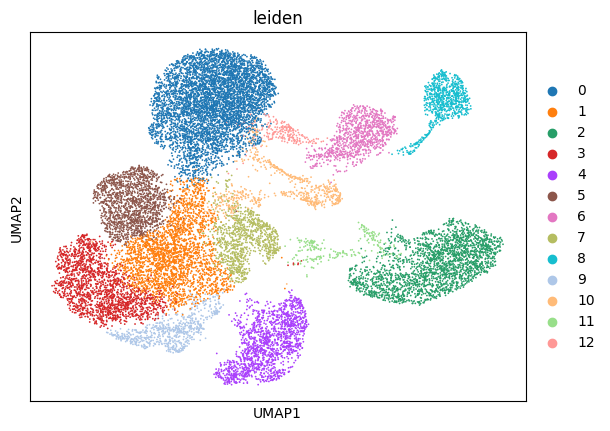

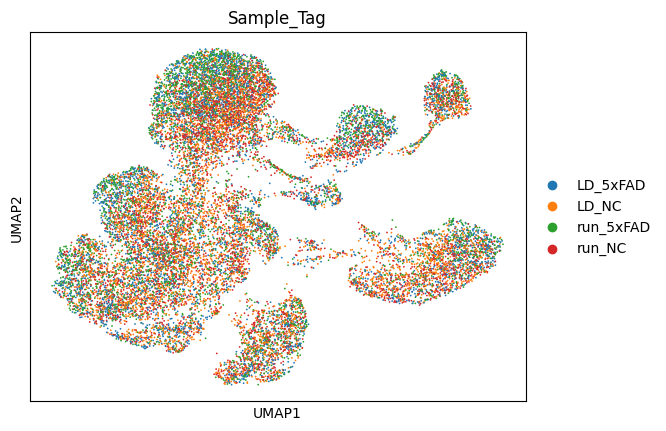

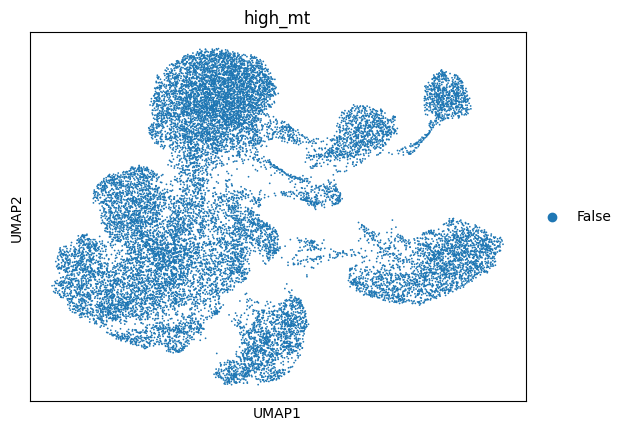

In [17]:
# Plotting
sc.pl.umap(adata_test, color=['leiden'], save='umap_leiden.png')
sc.pl.umap(adata_test, color=['Sample_Tag'], save='umap_sampletag.png')
sc.pl.umap(adata_test, color=['high_mt'], save='umap_highmt.png')

# Cluster annotation

In [18]:
assign_unique_cell_type_names(adata_test, cluster_key='leiden', cluster_types=['class_name', 'subclass_name'])

# Cluster annotation visualization

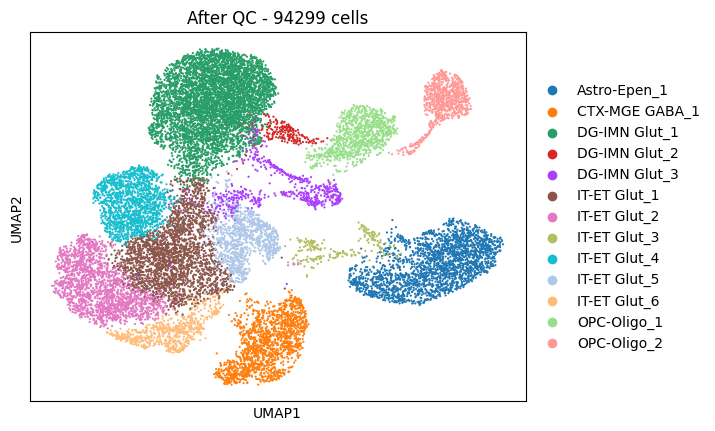

In [19]:
# Plot UMAP with unique cell type annotations
sc.pl.umap(adata_test, color=['cluster_class_name'], save='umap_all_groups.png', title=f'After QC - {adata.shape[0]} cells', size=10)

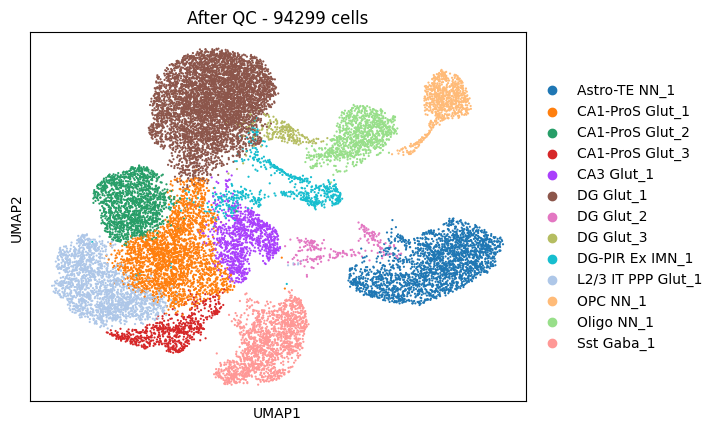

In [20]:
# Plot UMAP with unique cell type annotations
sc.pl.umap(adata_test, color=['cluster_subclass_name'], save='umap_all_groups.png', title=f'After QC - {adata.shape[0]} cells', size=10)

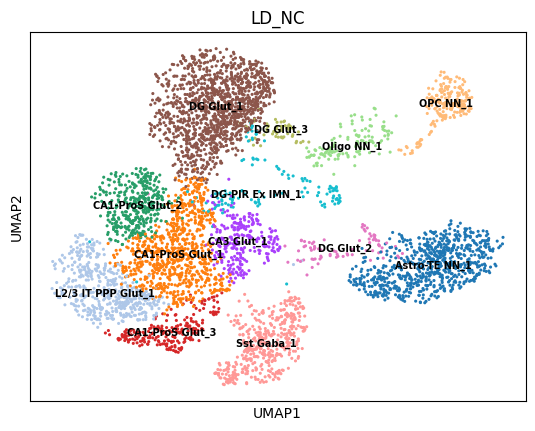

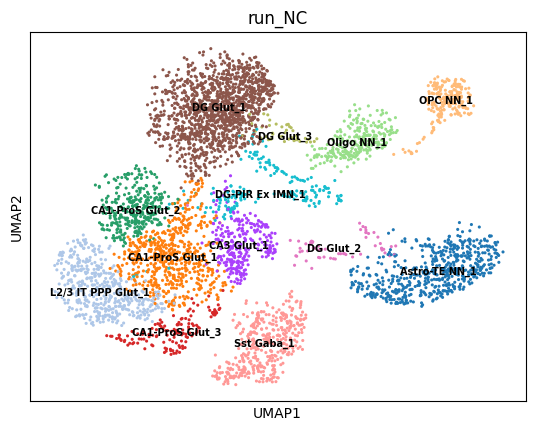

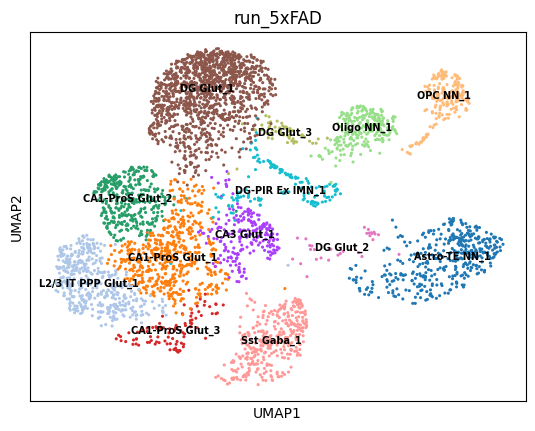

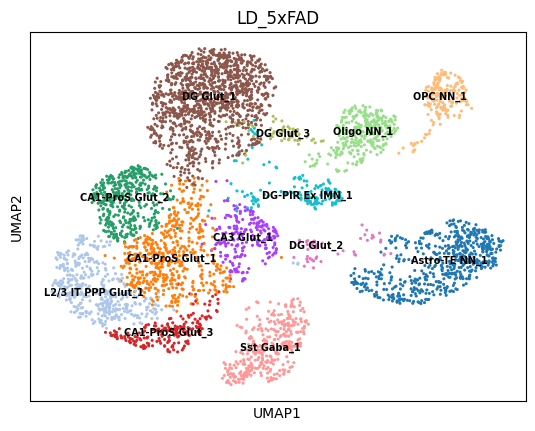

In [21]:
# Plot separately by sample tag
sample_tags = adata_test.obs['Sample_Tag'].unique()
plot_umap(adata_test, cluster_type='cluster_subclass_name', legend_fontsize=7, save_path='_sample_tag')

# Clusters composition analysis

In [ ]:
class_level, cluster_type = 'subclass_name', 'cluster_subclass_name'

In [ ]:
#create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata_test, ['WT-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/wt_dmso_ditto.png')
create_ditto_plot(adata_test, ['3xTg-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/3xtg_dmso_ditto.png')
create_ditto_plot(adata_test, ['WT-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/wt_scdi_ditto.png')
create_ditto_plot(adata_test, ['3xTg-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/3xtg_scdi_ditto.png')
create_ditto_plot(adata_test, ['Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/undetermined_ditto.png')

# Top contributing genes for each latent dimension

In [52]:
top_genes = get_top_genes(autoencoder, adata_test)

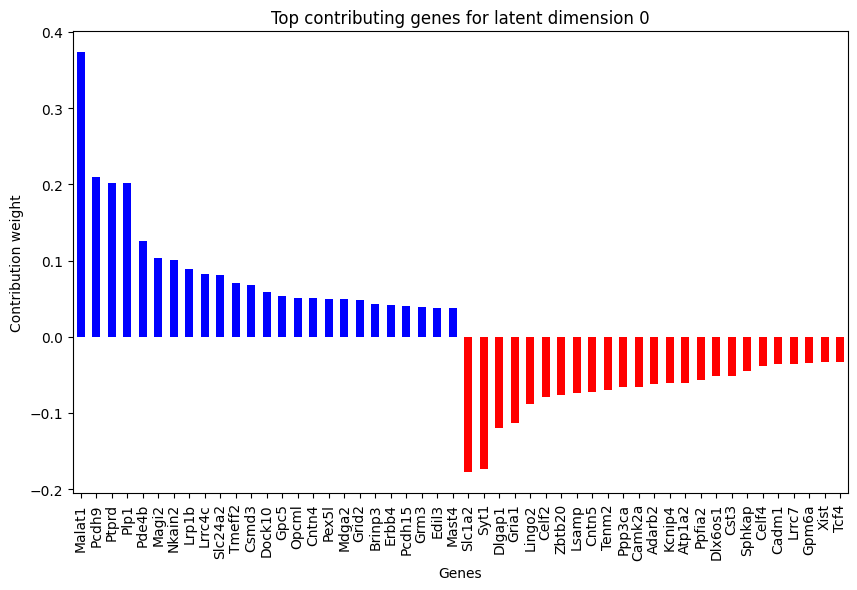

In [53]:
plot_top_contributing_genes(autoencoder, adata_test, latent_dim=0, top_n=25)

In [56]:
top_genes[i]

{'UP_genes_name': [], 'DOWN_genes_name': []}

# GO term enrichment analysis

In [65]:
UP_GO_results = []
DOWN_GO_results = []
UP_KEGG_results = []
DOWN_KEGG_results = []
for i in tqdm(range(32)):
    if len(top_genes[i]['UP_genes_name']) == 0 or len(top_genes[i]['DOWN_genes_name']) == 0:
        UP_GO_results.append(pd.DataFrame())
        DOWN_GO_results.append(pd.DataFrame())
        UP_KEGG_results.append(pd.DataFrame())
        DOWN_KEGG_results.append(pd.DataFrame())
        continue
    UP_GO = go_enrichment_analysis(top_genes[i]['UP_genes_name'], save_path=None)
    DOWN_GO = go_enrichment_analysis(top_genes[i]['DOWN_genes_name'], save_path=None)
    UP_KEGG = kegg_enrichment_analysis(top_genes[i]['UP_genes_name'], save_path=None)
    DOWN_KEGG = kegg_enrichment_analysis(top_genes[i]['DOWN_genes_name'], save_path=None)

    UP_GO_results.append(UP_GO)
    DOWN_GO_results.append(DOWN_GO)
    UP_KEGG_results.append(UP_KEGG)
    DOWN_KEGG_results.append(DOWN_KEGG)

100%|███████████████████████████████████████████| 32/32 [02:01<00:00,  3.79s/it]


In [66]:
idx=29

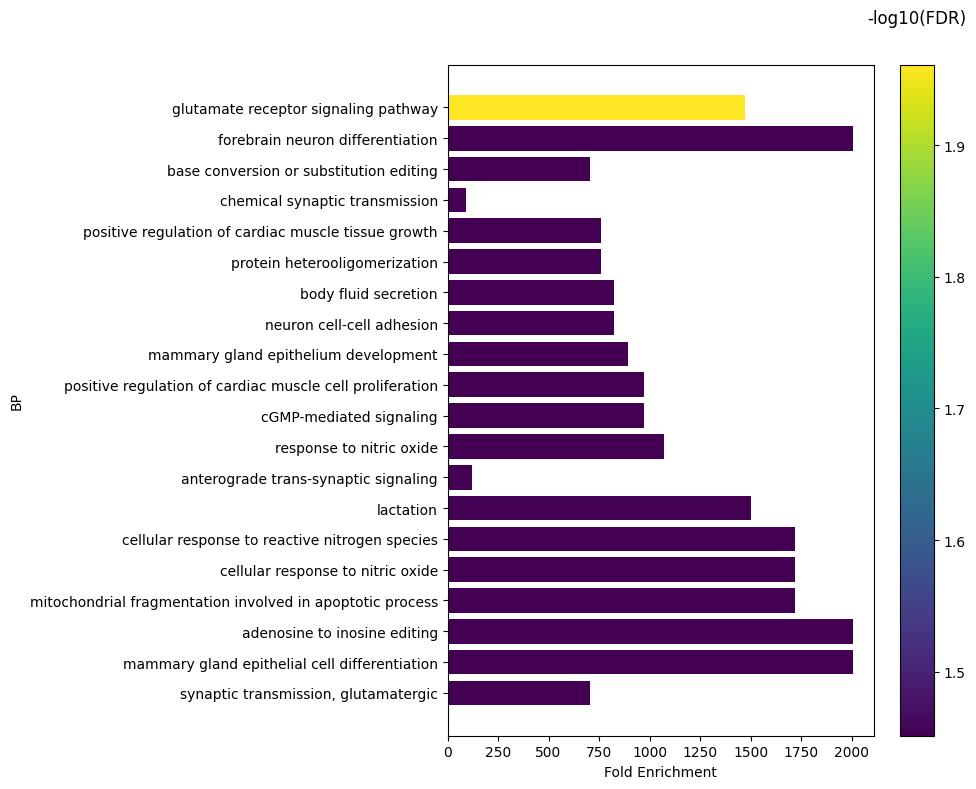

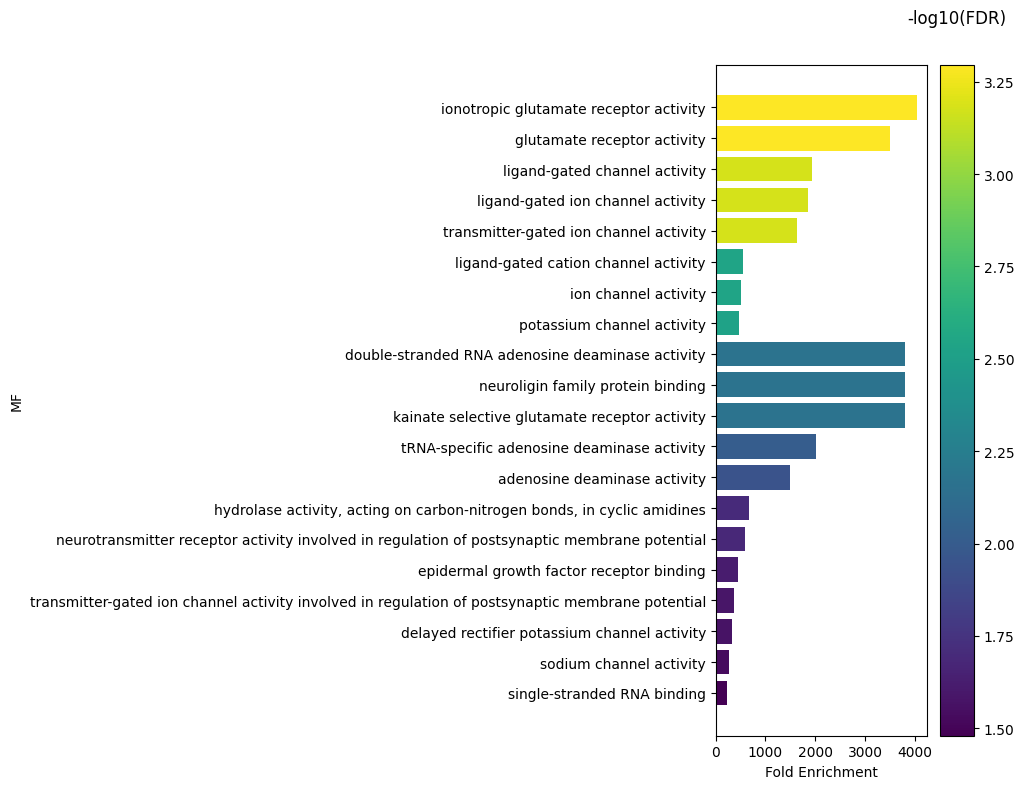

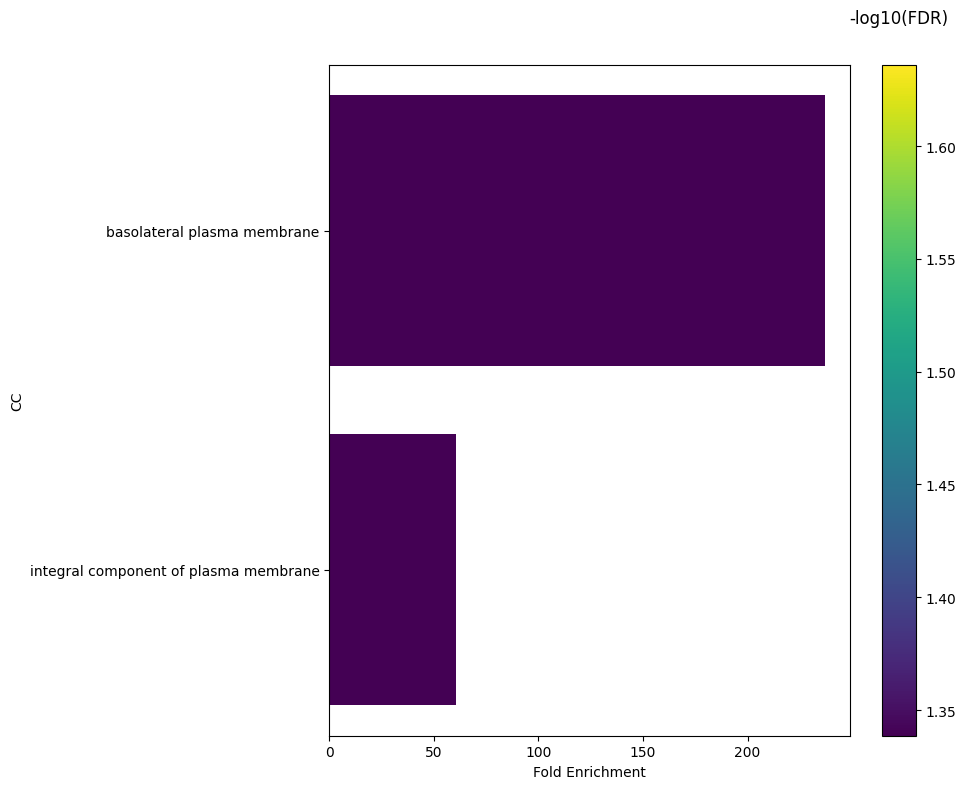

In [67]:
display_go_enrichment(UP_GO_results[idx], namespace='BP', fig_title=None, save_path=None)
display_go_enrichment(UP_GO_results[idx], namespace='MF', fig_title=None, save_path=None)
display_go_enrichment(UP_GO_results[idx], namespace='CC', fig_title=None, save_path=None)

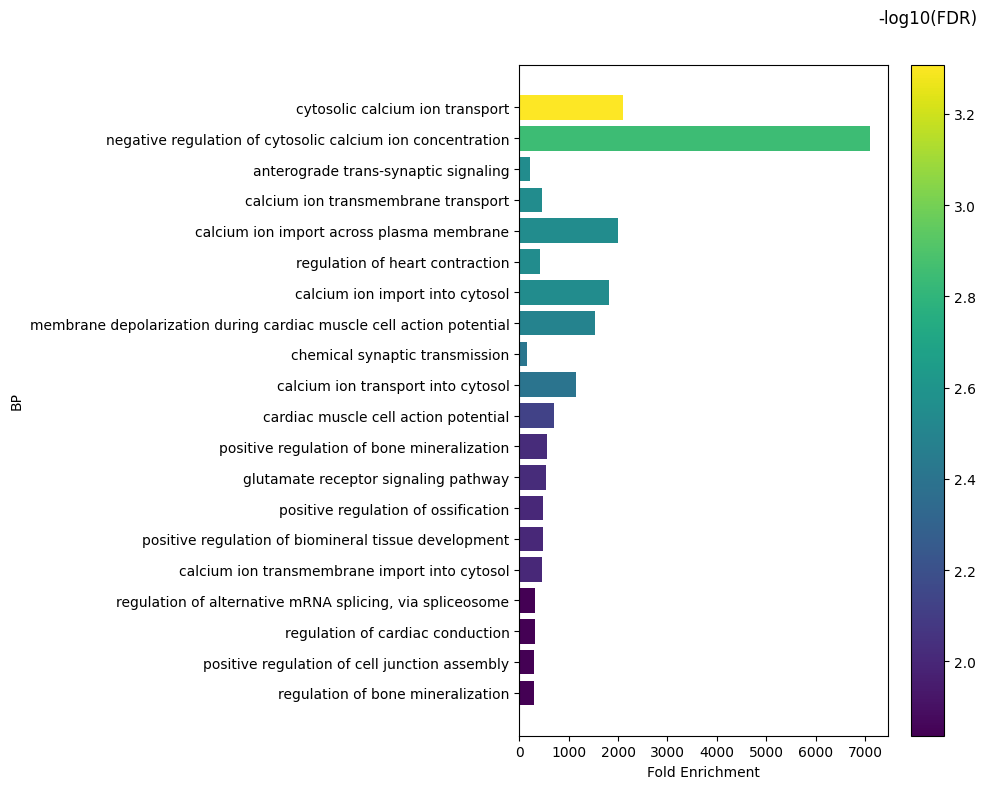

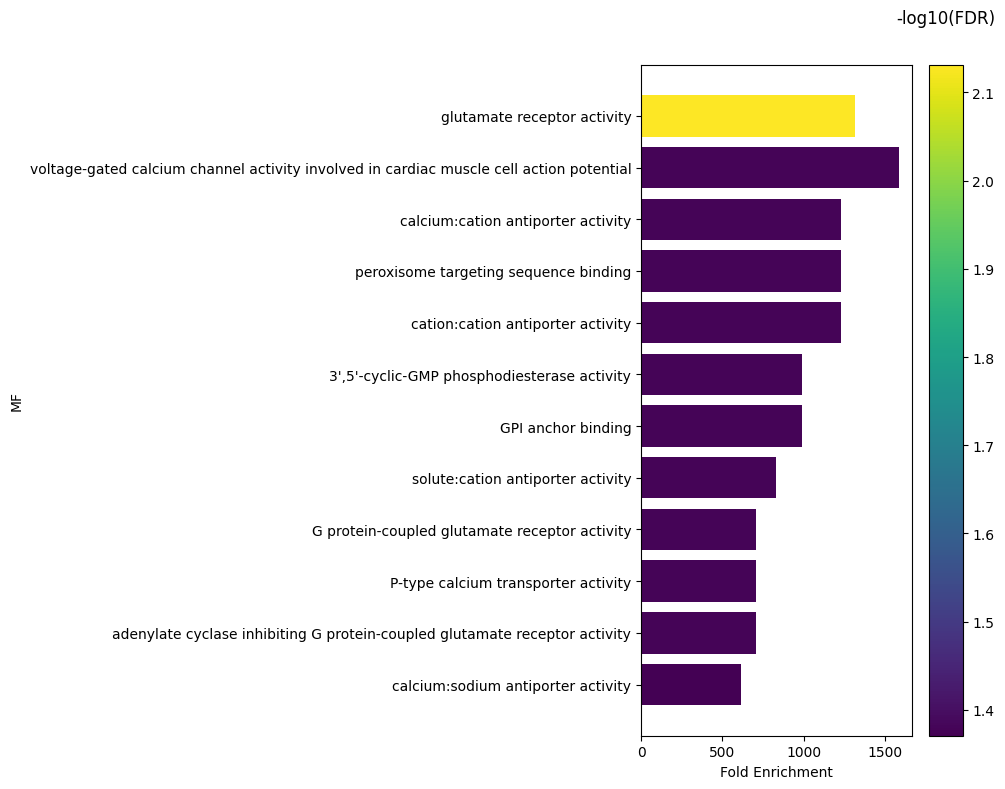

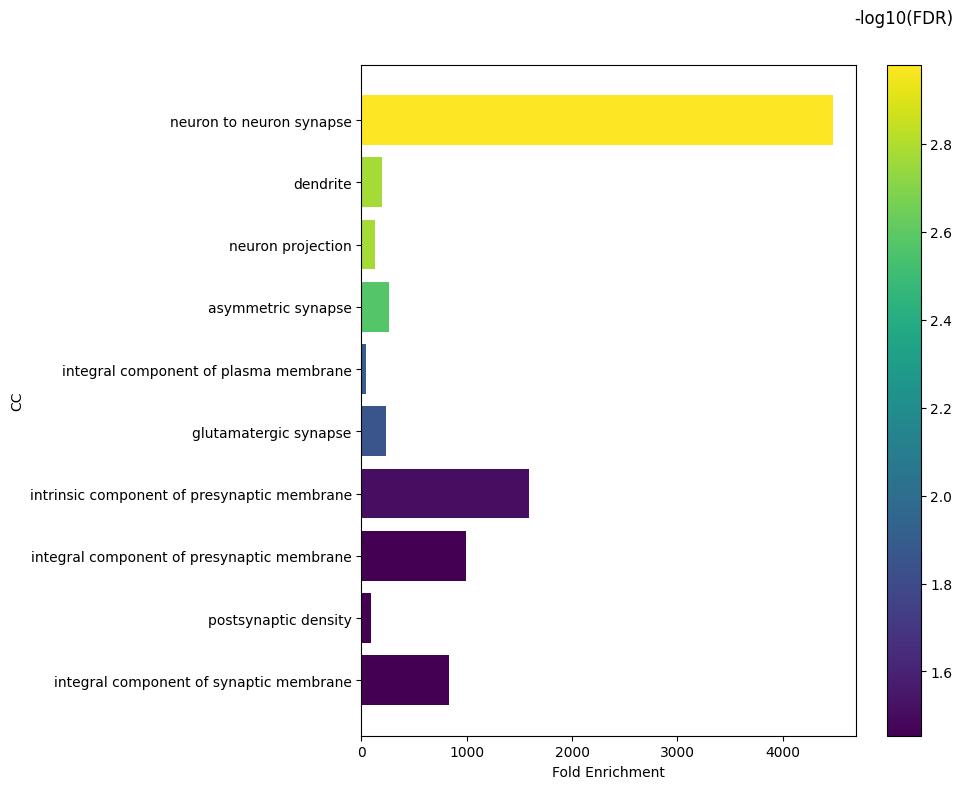

In [68]:
display_go_enrichment(DOWN_GO_results[idx], namespace='BP', fig_title=None, save_path=None)
display_go_enrichment(DOWN_GO_results[idx], namespace='MF', fig_title=None, save_path=None)
display_go_enrichment(DOWN_GO_results[idx], namespace='CC', fig_title=None, save_path=None)

/home/client/projects/sc_alz/modules/deg_analysis.py:385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(FDR)'] = -np.log10(df['p_fdr_bh'])


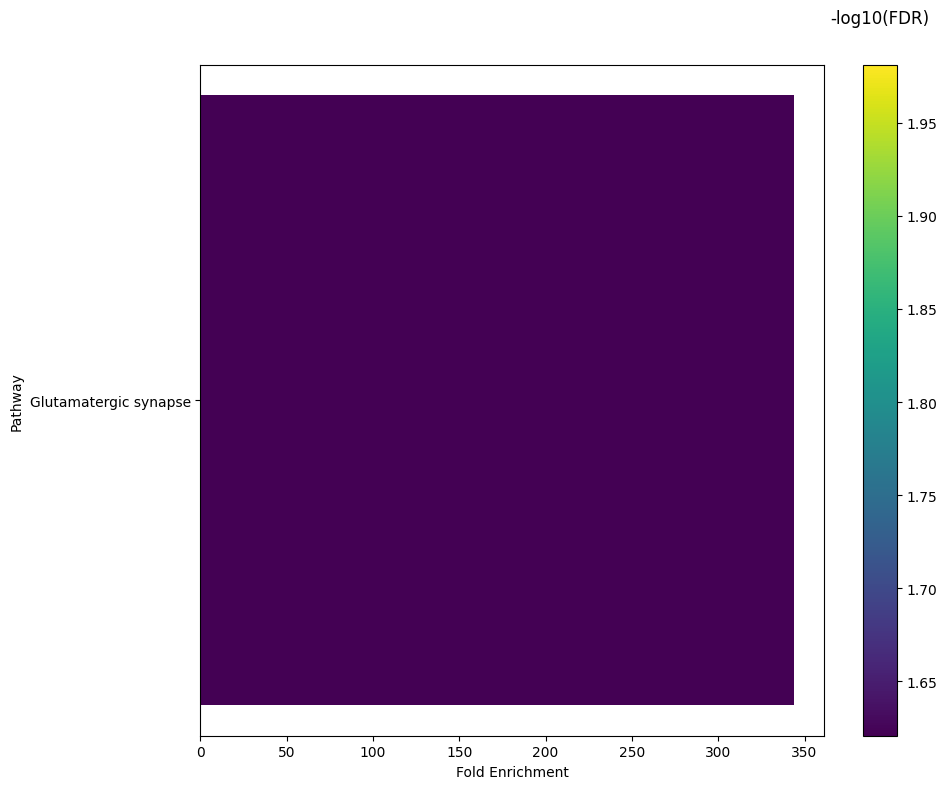

In [69]:
display_kegg_enrichment(UP_KEGG_results[idx], fig_title=None, save_path=None)

/home/client/projects/sc_alz/modules/deg_analysis.py:385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(FDR)'] = -np.log10(df['p_fdr_bh'])


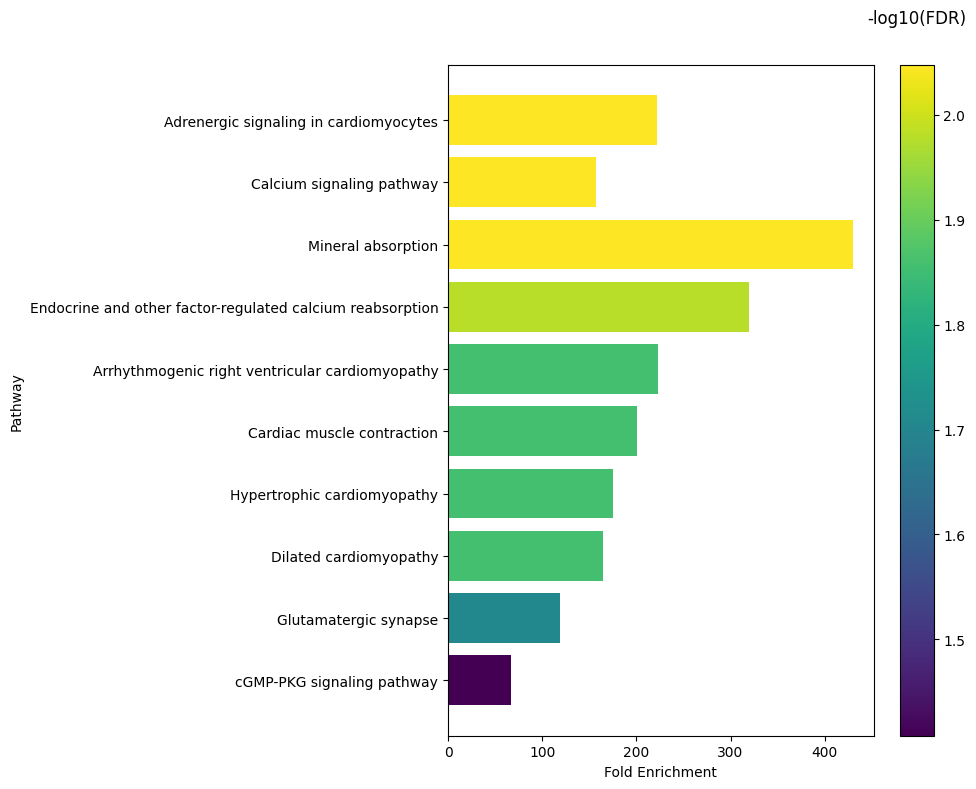

In [70]:
display_kegg_enrichment(DOWN_KEGG_results[idx], fig_title=None, save_path=None)

# Latent dimensions heatmap

In [22]:
tags = adata_test.obs['Sample_Tag'].unique().tolist()

In [28]:
classes = adata_test.obs['cluster_class_name'].unique().tolist()

In [29]:
classes

['IT-ET Glut_1',
 'IT-ET Glut_2',
 'DG-IMN Glut_1',
 'CTX-MGE GABA_1',
 'IT-ET Glut_3',
 'OPC-Oligo_1',
 'IT-ET Glut_4',
 'Astro-Epen_1',
 'IT-ET Glut_5',
 'DG-IMN Glut_2',
 'OPC-Oligo_2',
 'DG-IMN Glut_3',
 'IT-ET Glut_6']

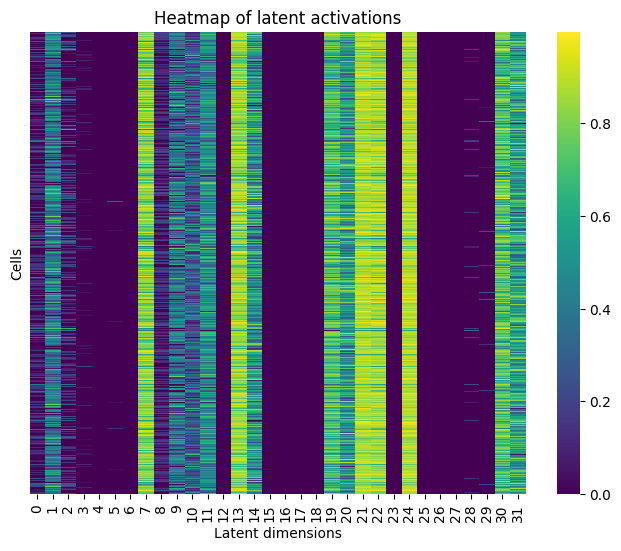

In [30]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=tags, clusters=['IT-ET Glut_1'], subclusters=None, num_cells=1000)

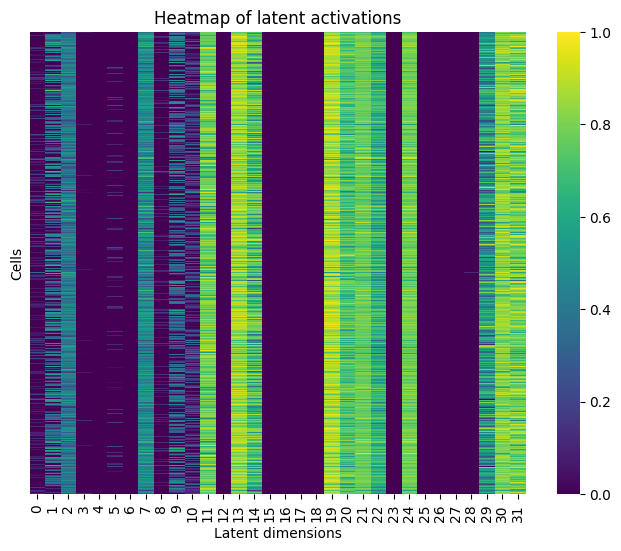

In [32]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=tags, clusters=['CTX-MGE GABA_1'], subclusters=None, num_cells=1000)